In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [7]:
img = cv.imread('export-2.png',0)
img2 = img.copy()
template_orig = cv.imread('template.jpg',0)

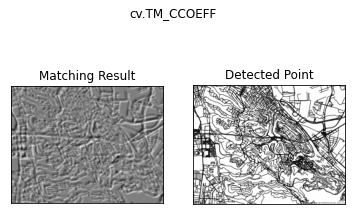

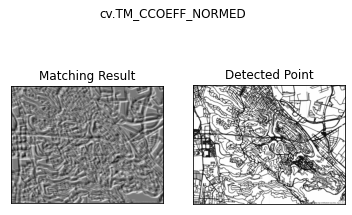

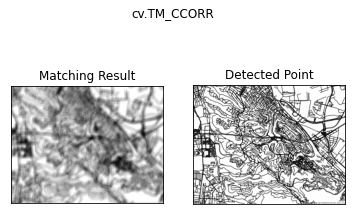

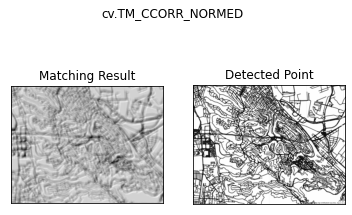

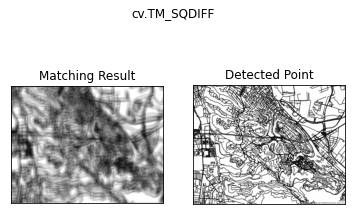

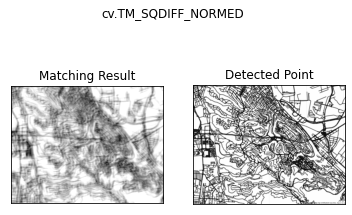

In [8]:
w, h = template_orig.shape[::-1]
scale_percent = 60 # percent of original size
width = int(w * scale_percent / 100)
height = int(h * scale_percent / 100)
dim = (width, height)
template = cv.resize(template_orig, dim, interpolation = cv.INTER_AREA) 
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [40]:
from PIL import Image, ImageDraw
import gpxpy as mod_gpxpy
from PIL import Image as mod_pil_image
from PIL import ImageDraw as mod_pil_draw
import glob as mod_glob
import math as mod_math
osm_tile_res = 256

In [29]:
def format_time(time_s):
    if not time_s:
        return 'n/a'
    minutes = mod_math.floor(time_s / 60.)
    hours = mod_math.floor(minutes / 60.)
    return '%s:%s:%s' % (str(int(hours)).zfill(2), str(int(minutes % 60)).zfill(2), str(int(time_s % 60)).zfill(2)) 

In [57]:
def get_map_suffix ():
#    return "osm-cycle"
#    return "seznam-turist"
    return "roads"


In [38]:
def osm_lat_lon_to_x_y_tile (lat_deg, lon_deg, zoom):
    """ Gets tile containing given coordinate at given zoom level """
    # taken from http://wiki.openstreetmap.org/wiki/Slippy_map_tilenames, works for OSM maps and mapy.cz
    lat_rad = mod_math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - mod_math.log(mod_math.tan(lat_rad) + (1 / mod_math.cos(lat_rad))) / mod_math.pi) / 2.0 * n)
    return (xtile, ytile)


def osm_get_auto_zoom_level ( min_lat, max_lat, min_lon, max_lon, max_n_tiles):
    """ Gets zoom level which contains at maximum `max_n_tiles` """
    for z in range (0,17):
        x1, y1 = osm_lat_lon_to_x_y_tile (min_lat, min_lon, z)
        x2, y2 = osm_lat_lon_to_x_y_tile (max_lat, max_lon, z)
        max_tiles = max (abs(x2 - x1), abs(y2 - y1))
        if (max_tiles > max_n_tiles):
            print ("Max tiles: %d" % max_tiles)
            return z 
    return 17


In [55]:
class MapCreator:
    """ Class for map drawing """

    def __init__(self, min_lat, max_lat, min_lon, max_lon, z):
        """ constructor """
        x1, y1 = osm_lat_lon_to_x_y_tile (min_lat, min_lon, z)
        x2, y2 = osm_lat_lon_to_x_y_tile (max_lat, max_lon, z)
        self.x1 = min (x1, x2)
        self.x2 = max (x1, x2)
        self.y1 = min (y1, y2)
        self.y2 = max (y1, y2)
        self.w = (self.x2 - self.x1 + 1) * osm_tile_res
        self.h = (self.y2 - self.y1 + 1) * osm_tile_res
        self.z = z
        print (self.w, self.h)
        self.dst_img = mod_pil_image.new ("RGB", (self.w, self.h), 'white')

    def lat_lon_to_image_xy (self, lat_deg, lon_deg):
        """ Internal. Converts lat, lon into dst_img coordinates in pixels """
        lat_rad = mod_math.radians(lat_deg)
        n = 2.0 ** self.z
        xtile_frac = (lon_deg + 180.0) / 360.0 * n
        ytile_frac = (1.0 - mod_math.log(mod_math.tan(lat_rad) + (1 / mod_math.cos(lat_rad))) / mod_math.pi) / 2.0 * n
        img_x = int( (xtile_frac-self.x1)*osm_tile_res )
        img_y = int( (ytile_frac-self.y1)*osm_tile_res )
        return (img_x, img_y)

    def draw_track (self, gpx):
        """ Draw GPX track onto map """
        draw = mod_pil_draw.Draw (self.dst_img)
        trk = 0         # Just changes color of segment a little
        for track in gpx.tracks:
            for segment in track.segments:
                idx = 0
                x_from = 0
                y_from = 0
                for point in segment.points:
                    if (idx == 0):
                        x_from, y_from = self.lat_lon_to_image_xy (point.latitude, point.longitude)
                    else:
                        x_to, y_to = self.lat_lon_to_image_xy (point.latitude, point.longitude)
#                        draw.line ((x_from,y_from,x_to,y_to), (255,0,trk), 2)
                        draw.line ((x_from,y_from,x_to,y_to), 'black', 3)
                        x_from = x_to
                        y_from = y_to
                    idx += 1
                trk += 32
                if (trk > 160):
                    trk = 0
                    
    def save_image(self, filename):
        print("Saving " + filename) 
        self.dst_img.save (filename)


In [30]:
gpx_files = mod_glob.glob (r"*.gpx")

In [56]:
for gpx_file in gpx_files:
        try:
            gpx = mod_gpxpy.parse(open(gpx_file))

            # Print some track stats
            print ('--------------------------------------------------------------------------------')
            print ('  GPX file     : %s' % gpx_file)
            start_time, end_time = gpx.get_time_bounds()
            print('  Started       : %s' % start_time)
            print('  Ended         : %s' % end_time)
            print('  Length        : %2.2fkm' % (gpx.length_3d() / 1000.))
            moving_time, stopped_time, moving_distance, stopped_distance, max_speed = gpx.get_moving_data()
            print('  Moving time   : %s' % format_time(moving_time))
            print('  Stopped time  : %s' % format_time(stopped_time))
#            print('  Max speed     : %2.2fm/s = %2.2fkm/h' % (max_speed, max_speed * 60. ** 2 / 1000.))    
            uphill, downhill = gpx.get_uphill_downhill()
            print('  Total uphill  : %4.0fm' % uphill)
            print('  Total downhill: %4.0fm' % downhill)
            min_lat, max_lat, min_lon, max_lon = gpx.get_bounds()
            print("  Bounds        : [%1.4f,%1.4f,%1.4f,%1.4f]" % (min_lat, max_lat, min_lon, max_lon))
            z = osm_get_auto_zoom_level (min_lat, max_lat, min_lon, max_lon, 6)
            print("  Zoom Level    : %d" % z)


            # Create the map
            map_creator = MapCreator (min_lat, max_lat, min_lon, max_lon, z)
            #map_creator.cache_area()
            #map_creator.create_area_background()
            map_creator.draw_track(gpx)
            map_creator.save_image (gpx_file[:-4] + '-' + get_map_suffix() + '.png')
            
        except Exception as e:
            mod_logging.exception(e)
            print('Error processing %s' % gpx_file)
            mod_sys.exit(1) 

--------------------------------------------------------------------------------
  GPX file     : export.gpx
  Started       : None
  Ended         : None
  Length        : 2131.98km
  Moving time   : n/a
  Stopped time  : n/a
  Total uphill  :    0m
  Total downhill:    0m
  Bounds        : [32.7073,32.8739,34.9471,35.1295]
Max tiles: 9
  Zoom Level    : 14
2304 2560
Saving export-seznam-turist.png


In [ ]:
pil_image = PIL.Image.open('Image.jpg').convert('RGB') 
open_cv_image = numpy.array(pil_image) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 